In [59]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from models import AR_RNN, compile_and_fit_tf


### data setup

In [61]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [62]:
area = "city of london"
monthly_data = utils.load_interpolated_data()

area_data = utils.get_area(monthly_data, area)


In [63]:
def format_data_for_RNN(area_data, cols, lookback, lookforward):
    train_df, test_df = train_test_split(area_data[cols],
                                         test_size=0.3,
                                         shuffle=False)

    # normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_df[cols] = scaler.fit_transform(train_df[cols])
    test_df[cols] = scaler.transform(test_df[cols])

    X_train, y_train = utils.create_windowed_dataset(train_df, cols, lookback,
                                                     lookforward)
    X_test, y_test = utils.create_windowed_dataset(test_df, cols, lookback,
                                                   lookforward)
    return train_df, test_df, X_train, y_train, X_test, y_test, scaler
    # return {'train_df':train_df, 'test_df':test_df, 'X_train':X_train, 'y_train':y_train, 'X_test':X_test, 'y_test':y_test, 'scaler':scaler}


In [64]:
def plot_inputs_outputs(area_data,
                        ground_truth,
                        train_ts,
                        test_ts,
                        cols,
                        col_idx,
                        lookback,
                        lookforward,
                        fwd_offset,
                        title=''):
    """ Args: 
            area_data: dataframe containing dates
            ground_truth: dataframe containing ground truth data
            train_ts: np array containing time series in the shape 
                (n_samples, lookback timesteps, n_features)
            test_ts: np array containing time series in the shape 
                (n_samples, lookforward timesteps, n_features)
            cols (str list): list of strings of features 
            col_idx (int): index of the feature to be plotted 
            lookback (int): number of timesteps in the lookback 
            lookforward (int): number of timesteps in the lookforward
            fwd_idx (int): which forward prediction/sample to plot
            title (str)
    """
    # fwd_idx = fwd_idx % lookforward
    col = cols[col_idx]
    plt.plot(area_data.date, ground_truth[col])
    plt.plot(area_data.date[range(lookback, lookback + len(train_ts))],
             train_ts[:, col_idx])
    plt.plot(
        area_data.date[range(
            lookback * 2 + fwd_offset + lookforward + len(train_ts),
            lookback * 2 + fwd_offset + lookforward + len(train_ts) +
            len(test_ts))], test_ts[:, col_idx])
    plt.title(title)

In [65]:
def plot_cumulative(area_data,
                    ground_truth_diff,
                    train_ts_diff,
                    test_ts_diff,
                    cols,
                    col_idx,
                    lookback,
                    lookforward,
                    fwd_offset=0,
                    title=''):
    init_train_offset = area_data.loc[lookback, 'average_price']
    init_test_offset = area_data.loc[lookback * 2 + fwd_offset + lookforward +
                                     len(train_ts_diff), 'average_price']
    plot_inputs_outputs(
        area_data,
        np.cumsum(ground_truth_diff) + init_train_offset,
        np.cumsum(train_ts_diff).reshape(-1, 1) + init_train_offset,
        np.cumsum(test_ts_diff).reshape(-1, 1) + init_test_offset, cols,
        col_idx, lookback, lookforward, fwd_offset, title)


## single-step prediction

### predict raw price

#### data setup

In [66]:
cols = ["average_price"]
lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [67]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 1)
(197, 1, 1)
(78, 12, 1)
(78, 1, 1)


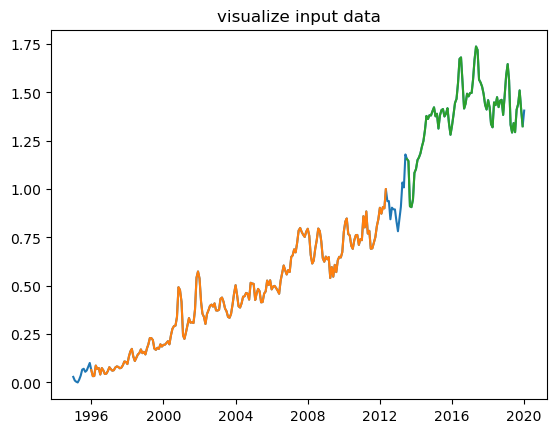

In [68]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [69]:
ar_rnn_model = AR_RNN(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
7/7 [==============================] - 3s 60ms/step - loss: 0.0323 - mean_absolute_error: 0.1443 - val_loss: 0.5899 - val_mean_absolute_error: 0.7522
Epoch 2/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0142 - mean_absolute_error: 0.0863 - val_loss: 0.1751 - val_mean_absolute_error: 0.3967
Epoch 3/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0075 - mean_absolute_error: 0.0681 - val_loss: 0.2295 - val_mean_absolute_error: 0.4618
Epoch 4/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0053 - mean_absolute_error: 0.0586 - val_loss: 0.1284 - val_mean_absolute_error: 0.3398
Epoch 5/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0053 - mean_absolute_error: 0.0567 - val_loss: 0.1425 - val_mean_absolute_error: 0.3599
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0044 - mean_absolute_error: 0.0521 - val_loss: 0.1345 - val_mean_absolute_error: 0.3497
Epoch 7/50
7/7 [==================

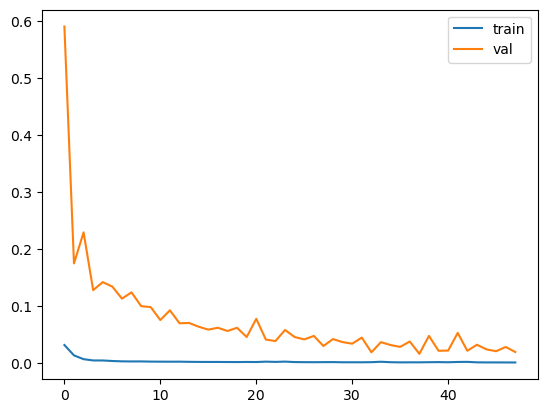

In [70]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

3/3 [==============================] - 0s 3ms/step


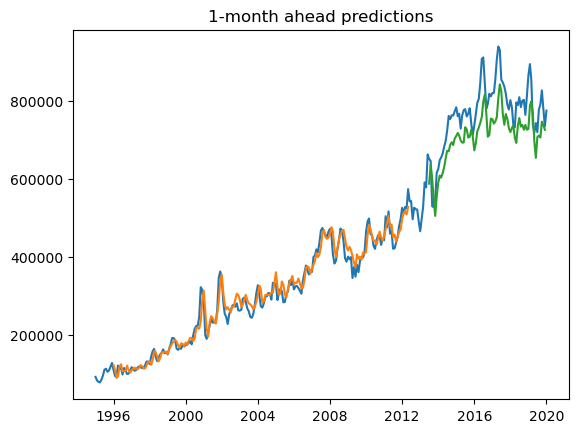

In [71]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-month ahead predictions')


In [72]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])

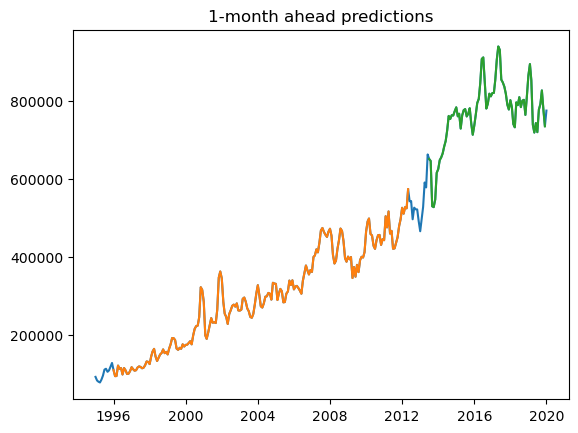

In [73]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_1mo_train_rescaled,
                    test_ts=y_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-month ahead predictions')


compute RMSE

In [74]:
print('Train RMSE: {}'.format(
    np.sqrt(mean_squared_error(pred_1mo_train_rescaled, y_1mo_train_rescaled))))
print('Test RMSE: {}'.format(
    np.sqrt(mean_squared_error(pred_1mo_test_rescaled, y_1mo_test_rescaled))))


Train RMSE: 20930.26571244654
Test RMSE: 70357.27955626063


### multiple features

#### data

In [75]:
cols = [
    'average_price', 'year', 'month', 'average_price_d1', 'median_salary',
    'population_size', 'number_of_jobs', 'no_of_houses'
]  # w no nans

lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [76]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 8)
(197, 1, 8)
(78, 12, 8)
(78, 1, 8)


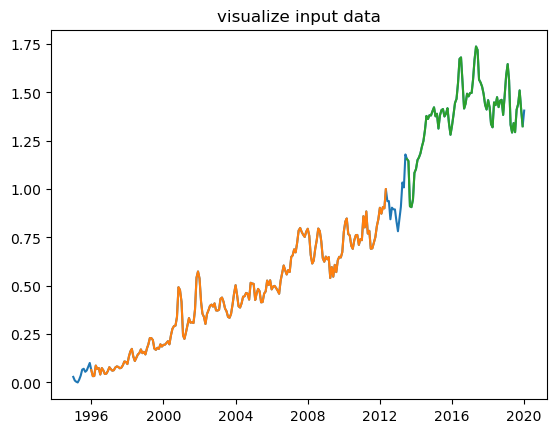

In [77]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [78]:
ar_rnn_model = AR_RNN(
    units=256,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=100,
                             patience=20)


Epoch 1/100
7/7 [==============================] - 2s 72ms/step - loss: 0.1497 - mean_absolute_error: 0.2825 - val_loss: 1.2219 - val_mean_absolute_error: 0.8295
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0363 - mean_absolute_error: 0.1483 - val_loss: 0.9023 - val_mean_absolute_error: 0.6943
Epoch 3/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0206 - mean_absolute_error: 0.1117 - val_loss: 0.6511 - val_mean_absolute_error: 0.5701
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0128 - mean_absolute_error: 0.0875 - val_loss: 0.5877 - val_mean_absolute_error: 0.5337
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0090 - mean_absolute_error: 0.0728 - val_loss: 0.5357 - val_mean_absolute_error: 0.5122
Epoch 6/100
7/7 [==============================] - 0s 19ms/step - loss: 0.0070 - mean_absolute_error: 0.0642 - val_loss: 0.5175 - val_mean_absolute_error: 0.4976
Epoch 7/100
7/7 [===========

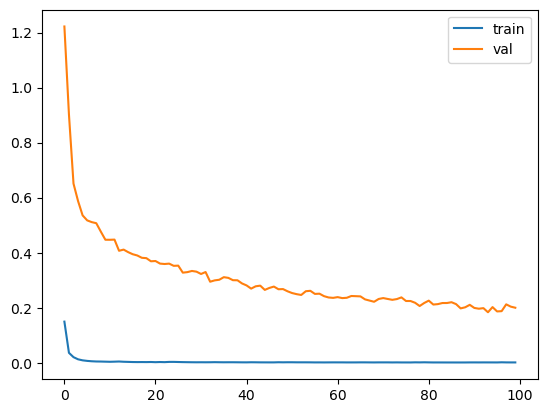

In [79]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [80]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

3/3 [==============================] - 0s 5ms/step


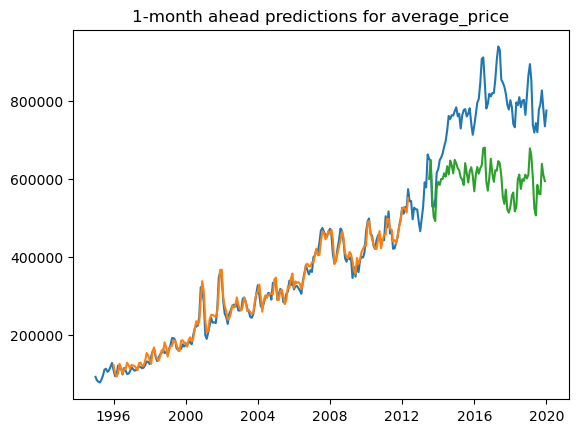

In [81]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


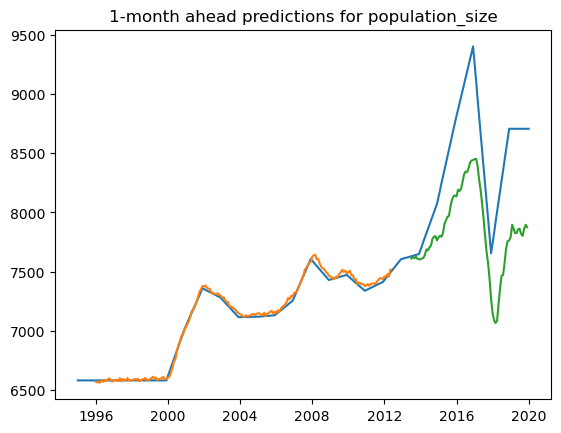

In [82]:
col_idx = 5
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


In [83]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])

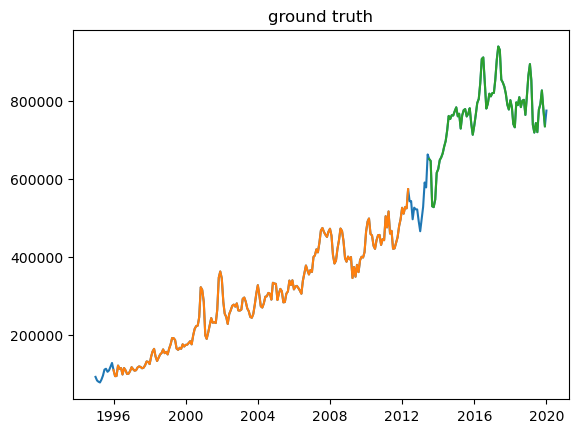

In [84]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_1mo_train_rescaled,
                    test_ts=y_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='ground truth')


compute RMSE

In [85]:
print('Train RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_train_rescaled[:, 0],
                           y_1mo_train_rescaled[:, 0]))))
print('Test RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_test_rescaled[:, 0],
                           y_1mo_test_rescaled[:, 0]))))


Train RMSE: 14479.394901290456
Test RMSE: 186850.88927717428


### predict diff

#### data

In [86]:
cols = ['average_price_d1']
lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [87]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 1)
(197, 1, 1)
(78, 12, 1)
(78, 1, 1)


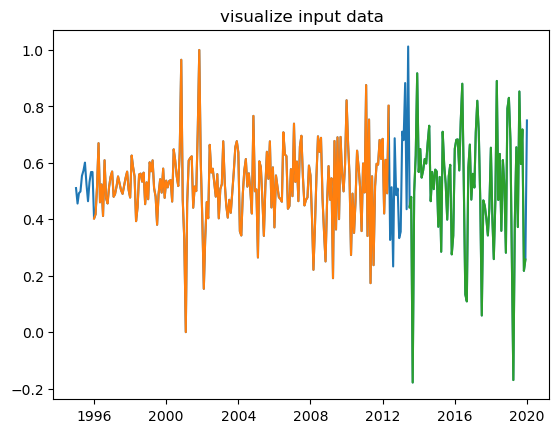

In [88]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [89]:
ar_rnn_model = AR_RNN(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
7/7 [==============================] - 2s 117ms/step - loss: 0.3236 - mean_absolute_error: 0.4488 - val_loss: 0.1867 - val_mean_absolute_error: 0.3648
Epoch 2/50
7/7 [==============================] - 0s 46ms/step - loss: 0.0839 - mean_absolute_error: 0.2453 - val_loss: 0.0588 - val_mean_absolute_error: 0.1801
Epoch 3/50
7/7 [==============================] - 0s 26ms/step - loss: 0.0398 - mean_absolute_error: 0.1635 - val_loss: 0.0698 - val_mean_absolute_error: 0.2112
Epoch 4/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0232 - mean_absolute_error: 0.1185 - val_loss: 0.0614 - val_mean_absolute_error: 0.1818
Epoch 5/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0212 - mean_absolute_error: 0.1121 - val_loss: 0.0563 - val_mean_absolute_error: 0.1751
Epoch 6/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0171 - mean_absolute_error: 0.0991 - val_loss: 0.0542 - val_mean_absolute_error: 0.1785
Epoch 7/50
7/7 [=================

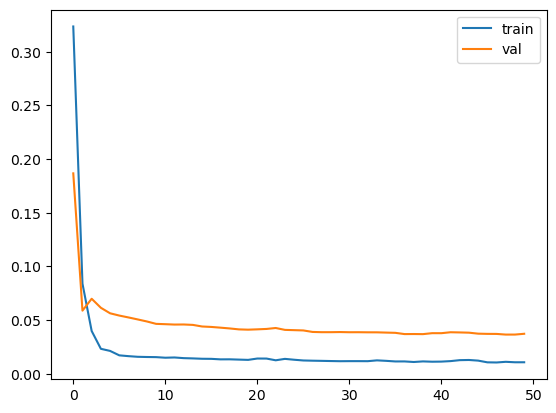

In [90]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [91]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

3/3 [==============================] - 0s 3ms/step


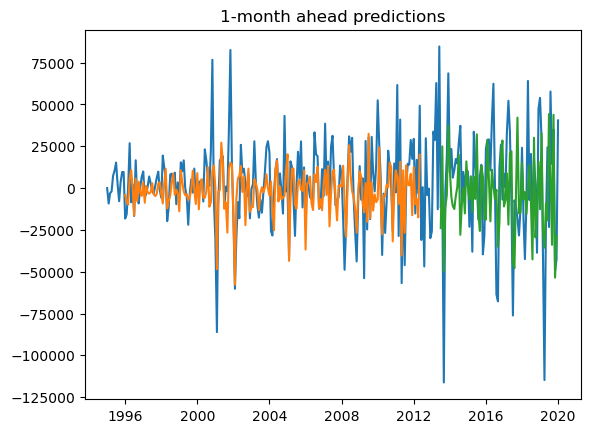

In [92]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=col_idx,
                    title='1-month ahead predictions')

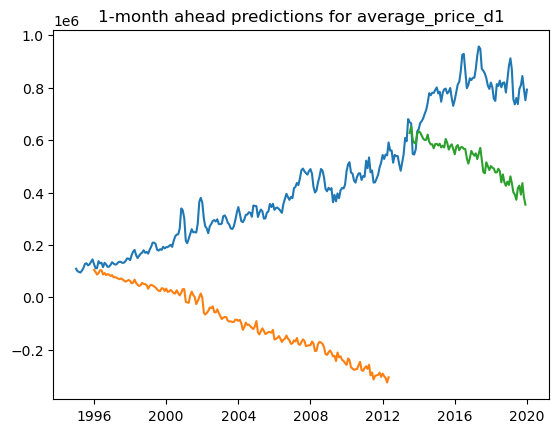

In [93]:
col_idx = 0
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_1mo_train_rescaled,
                test_ts_diff=pred_1mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=0,
                title=f'1-month ahead predictions for {cols[col_idx]}')


## autoregressive prediction

### predict raw

#### data setup

In [94]:
cols = ["average_price"]
lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [95]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 1)
(186, 12, 1)
(67, 12, 1)
(67, 12, 1)


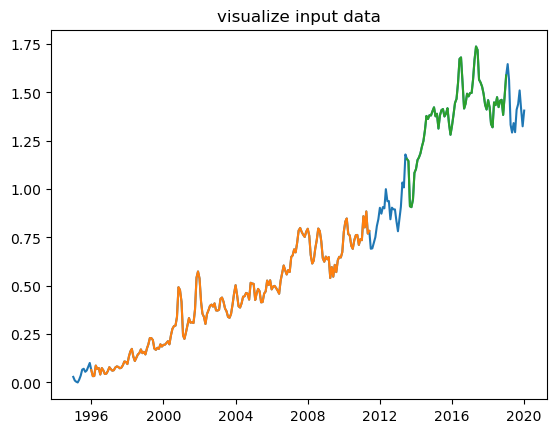

In [96]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [97]:
ar_rnn_model = AR_RNN(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
6/6 [==============================] - 2s 113ms/step - loss: 0.1565 - mean_absolute_error: 0.2872 - val_loss: 0.5180 - val_mean_absolute_error: 0.6983
Epoch 2/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0511 - mean_absolute_error: 0.1854 - val_loss: 0.9550 - val_mean_absolute_error: 0.9530
Epoch 3/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0351 - mean_absolute_error: 0.1420 - val_loss: 0.9170 - val_mean_absolute_error: 0.9371
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0193 - mean_absolute_error: 0.1086 - val_loss: 0.5586 - val_mean_absolute_error: 0.7305
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0148 - mean_absolute_error: 0.0980 - val_loss: 0.5542 - val_mean_absolute_error: 0.7291
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0125 - mean_absolute_error: 0.0918 - val_loss: 0.4620 - val_mean_absolute_error: 0.6651
Epoch 7/50
6/6 [=================

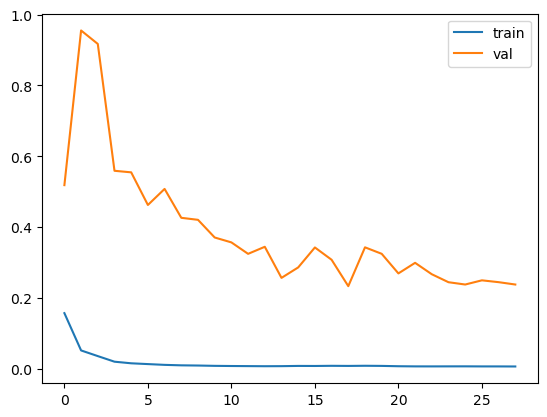

In [98]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [99]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 3ms/step


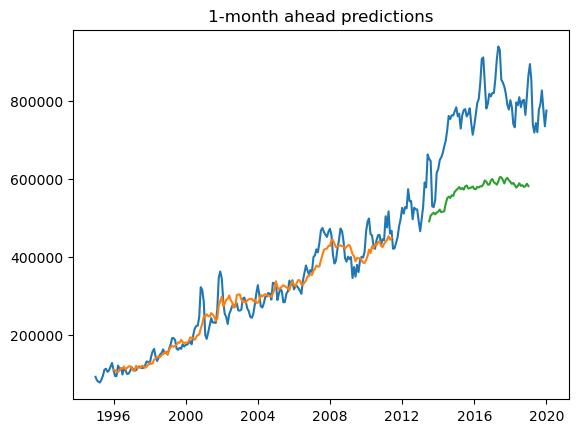

In [100]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-month ahead predictions')

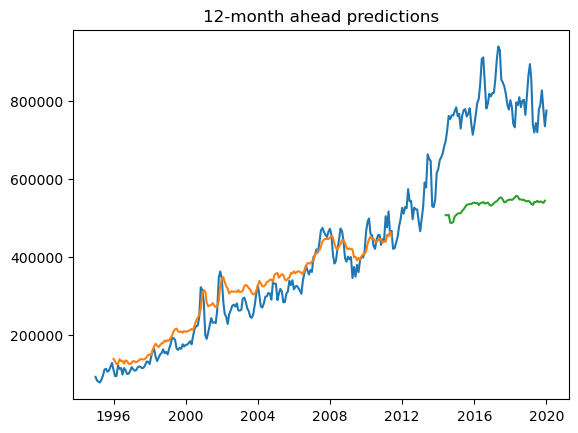

In [101]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title='12-month ahead predictions')


In [102]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])
y_12mo_train_rescaled = scaler.inverse_transform(y_train[:, -1])
y_12mo_test_rescaled = scaler.inverse_transform(y_test[:, -1])

In [103]:
y_1mo_train_rescaled.shape

(186, 1)

In [104]:
print('Train 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_train_rescaled[:, 0],
                           y_1mo_train_rescaled[:, 0]))))
print('Test 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_test_rescaled[:, 0],
                           y_1mo_test_rescaled[:, 0]))))

print('Train 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_train_rescaled[:, 0],
                           y_12mo_train_rescaled[:, 0]))))
print('Test 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_test_rescaled[:, 0],
                           y_12mo_test_rescaled[:, 0]))))


Train 1mo RMSE: 30906.335052843995
Test 1mo RMSE: 207993.35103086435
Train 12mo RMSE: 41489.26125430395
Test 12mo RMSE: 265113.54756633245


### multiple features

#### data setup

In [105]:
cols = [
    'average_price', 'year', 'month', 'average_price_d1', 'median_salary',
    'population_size', 'number_of_jobs', 'no_of_houses'
]  # w no nans

lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [106]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 8)
(186, 12, 8)
(67, 12, 8)
(67, 12, 8)


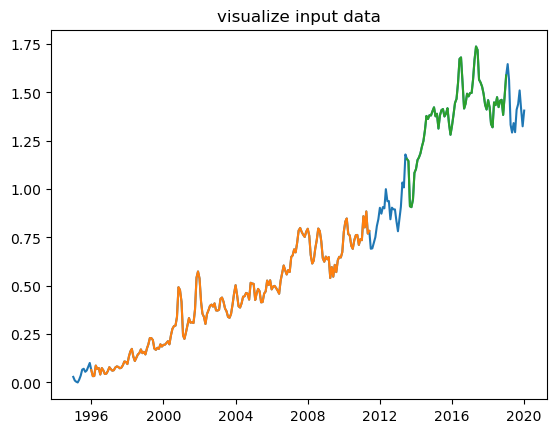

In [107]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [108]:
ar_rnn_model = AR_RNN(
    units=256,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=100,
                             patience=20)


Epoch 1/100
6/6 [==============================] - 3s 114ms/step - loss: 0.1850 - mean_absolute_error: 0.3259 - val_loss: 1.5027 - val_mean_absolute_error: 0.9383
Epoch 2/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0460 - mean_absolute_error: 0.1683 - val_loss: 1.4869 - val_mean_absolute_error: 0.9576
Epoch 3/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0278 - mean_absolute_error: 0.1276 - val_loss: 1.3510 - val_mean_absolute_error: 0.8674
Epoch 4/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0233 - mean_absolute_error: 0.1167 - val_loss: 1.1870 - val_mean_absolute_error: 0.8042
Epoch 5/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0183 - mean_absolute_error: 0.1042 - val_loss: 1.1481 - val_mean_absolute_error: 0.7843
Epoch 6/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0133 - mean_absolute_error: 0.0857 - val_loss: 1.0495 - val_mean_absolute_error: 0.7402
Epoch 7/100
6/6 [==========

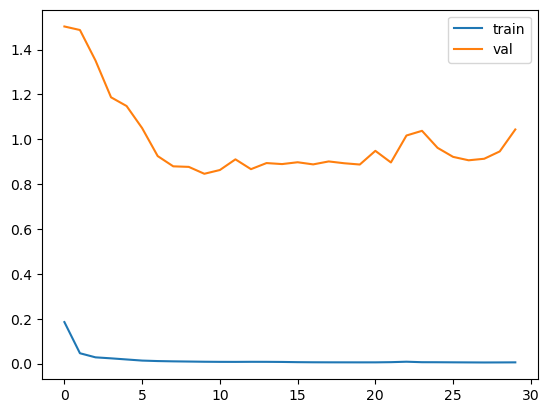

In [109]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [110]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 5ms/step


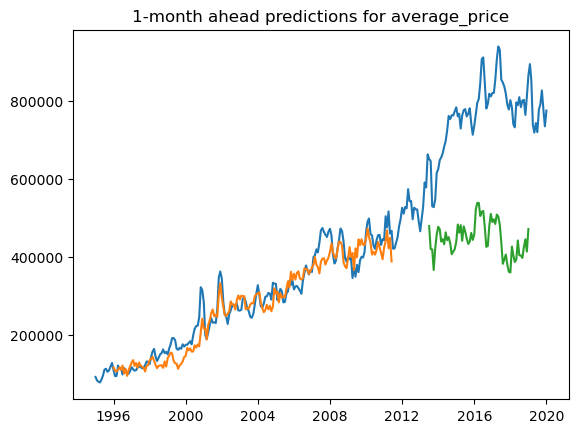

In [111]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


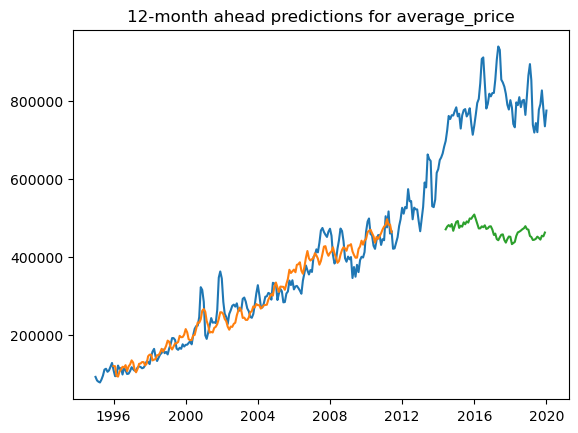

In [112]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title=f'12-month ahead predictions for {cols[col_idx]}')


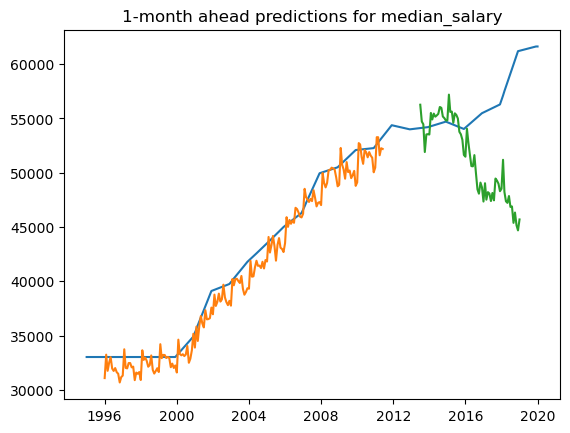

In [113]:
col_idx = 4
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


In [114]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])
y_12mo_train_rescaled = scaler.inverse_transform(y_train[:, -1])
y_12mo_test_rescaled = scaler.inverse_transform(y_test[:, -1])

In [115]:
y_1mo_train_rescaled.shape

(186, 8)

In [116]:
print('Train 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_train_rescaled[:, 0],
                           y_1mo_train_rescaled[:, 0]))))
print('Test 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_test_rescaled[:, 0],
                           y_1mo_test_rescaled[:, 0]))))

print('Train 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_train_rescaled[:, 0],
                           y_12mo_train_rescaled[:, 0]))))
print('Test 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_test_rescaled[:, 0],
                           y_12mo_test_rescaled[:, 0]))))


Train 1mo RMSE: 34098.08346306023
Test 1mo RMSE: 331937.9886510778
Train 12mo RMSE: 38259.4776249995
Test 12mo RMSE: 333064.31062011706


### predict diff

#### data

In [117]:
cols = ['average_price_d1']
lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [118]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 1)
(186, 12, 1)
(67, 12, 1)
(67, 12, 1)


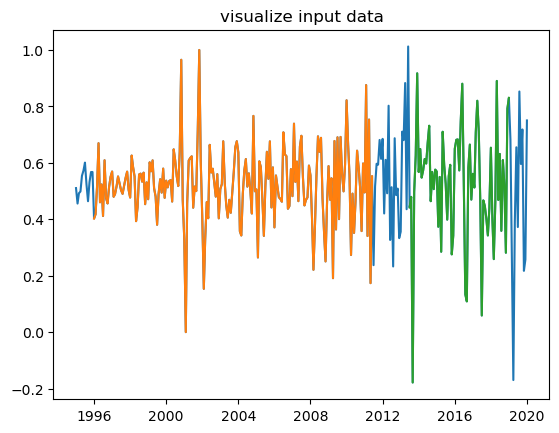

In [119]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [120]:
ar_rnn_model = AR_RNN(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
6/6 [==============================] - 2s 98ms/step - loss: 0.0744 - mean_absolute_error: 0.2142 - val_loss: 0.0616 - val_mean_absolute_error: 0.1904
Epoch 2/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0268 - mean_absolute_error: 0.1250 - val_loss: 0.0528 - val_mean_absolute_error: 0.1872
Epoch 3/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0221 - mean_absolute_error: 0.1110 - val_loss: 0.0444 - val_mean_absolute_error: 0.1586
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0201 - mean_absolute_error: 0.1034 - val_loss: 0.0422 - val_mean_absolute_error: 0.1594
Epoch 5/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0185 - mean_absolute_error: 0.1002 - val_loss: 0.0421 - val_mean_absolute_error: 0.1582
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0174 - mean_absolute_error: 0.0959 - val_loss: 0.0422 - val_mean_absolute_error: 0.1557
Epoch 7/50
6/6 [==================

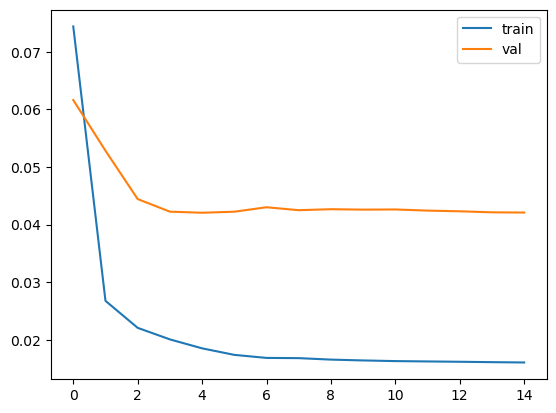

In [121]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [122]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 37ms/step


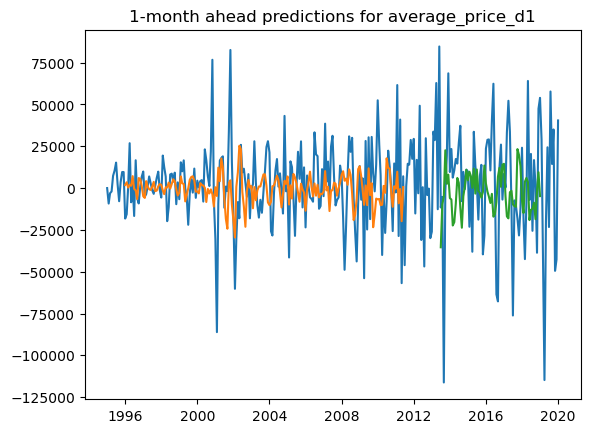

In [123]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


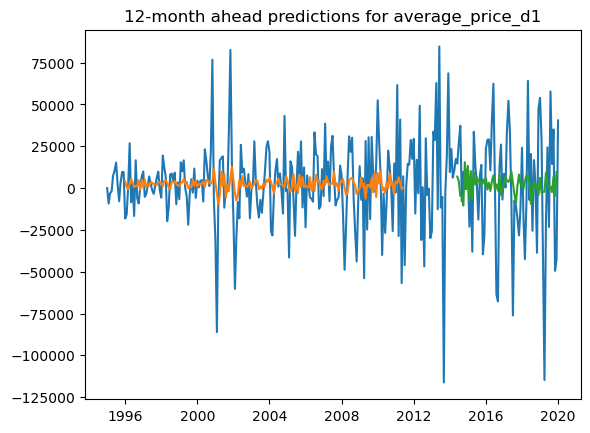

In [124]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title=f'12-month ahead predictions for {cols[col_idx]}')


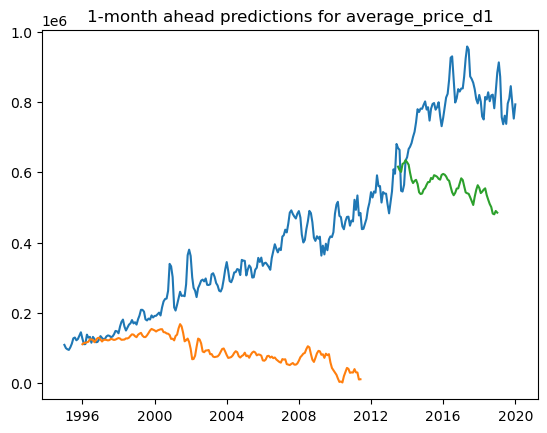

In [125]:
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_1mo_train_rescaled,
                test_ts_diff=pred_1mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=0,
                title=f'1-month ahead predictions for {cols[col_idx]}')


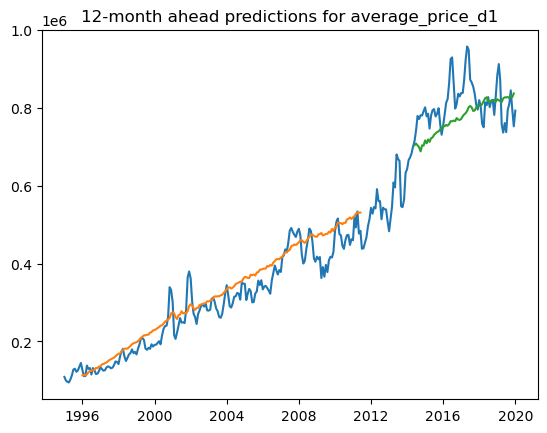

In [126]:
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_12mo_train_rescaled,
                test_ts_diff=pred_12mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=11,
                title=f'12-month ahead predictions for {cols[col_idx]}')
